In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import poisson, expon, gamma
from scipy.special import factorial

from get_model_training_data_05 import get_features_and_data

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

# warnings.filterwarnings("ignore")
# os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
(df, train_df, test_df, feature_names, next_month) = get_features_and_data()

training examples = 2425, testing examples = 270


<Axes: xlabel='index', ylabel='prob_of_release'>

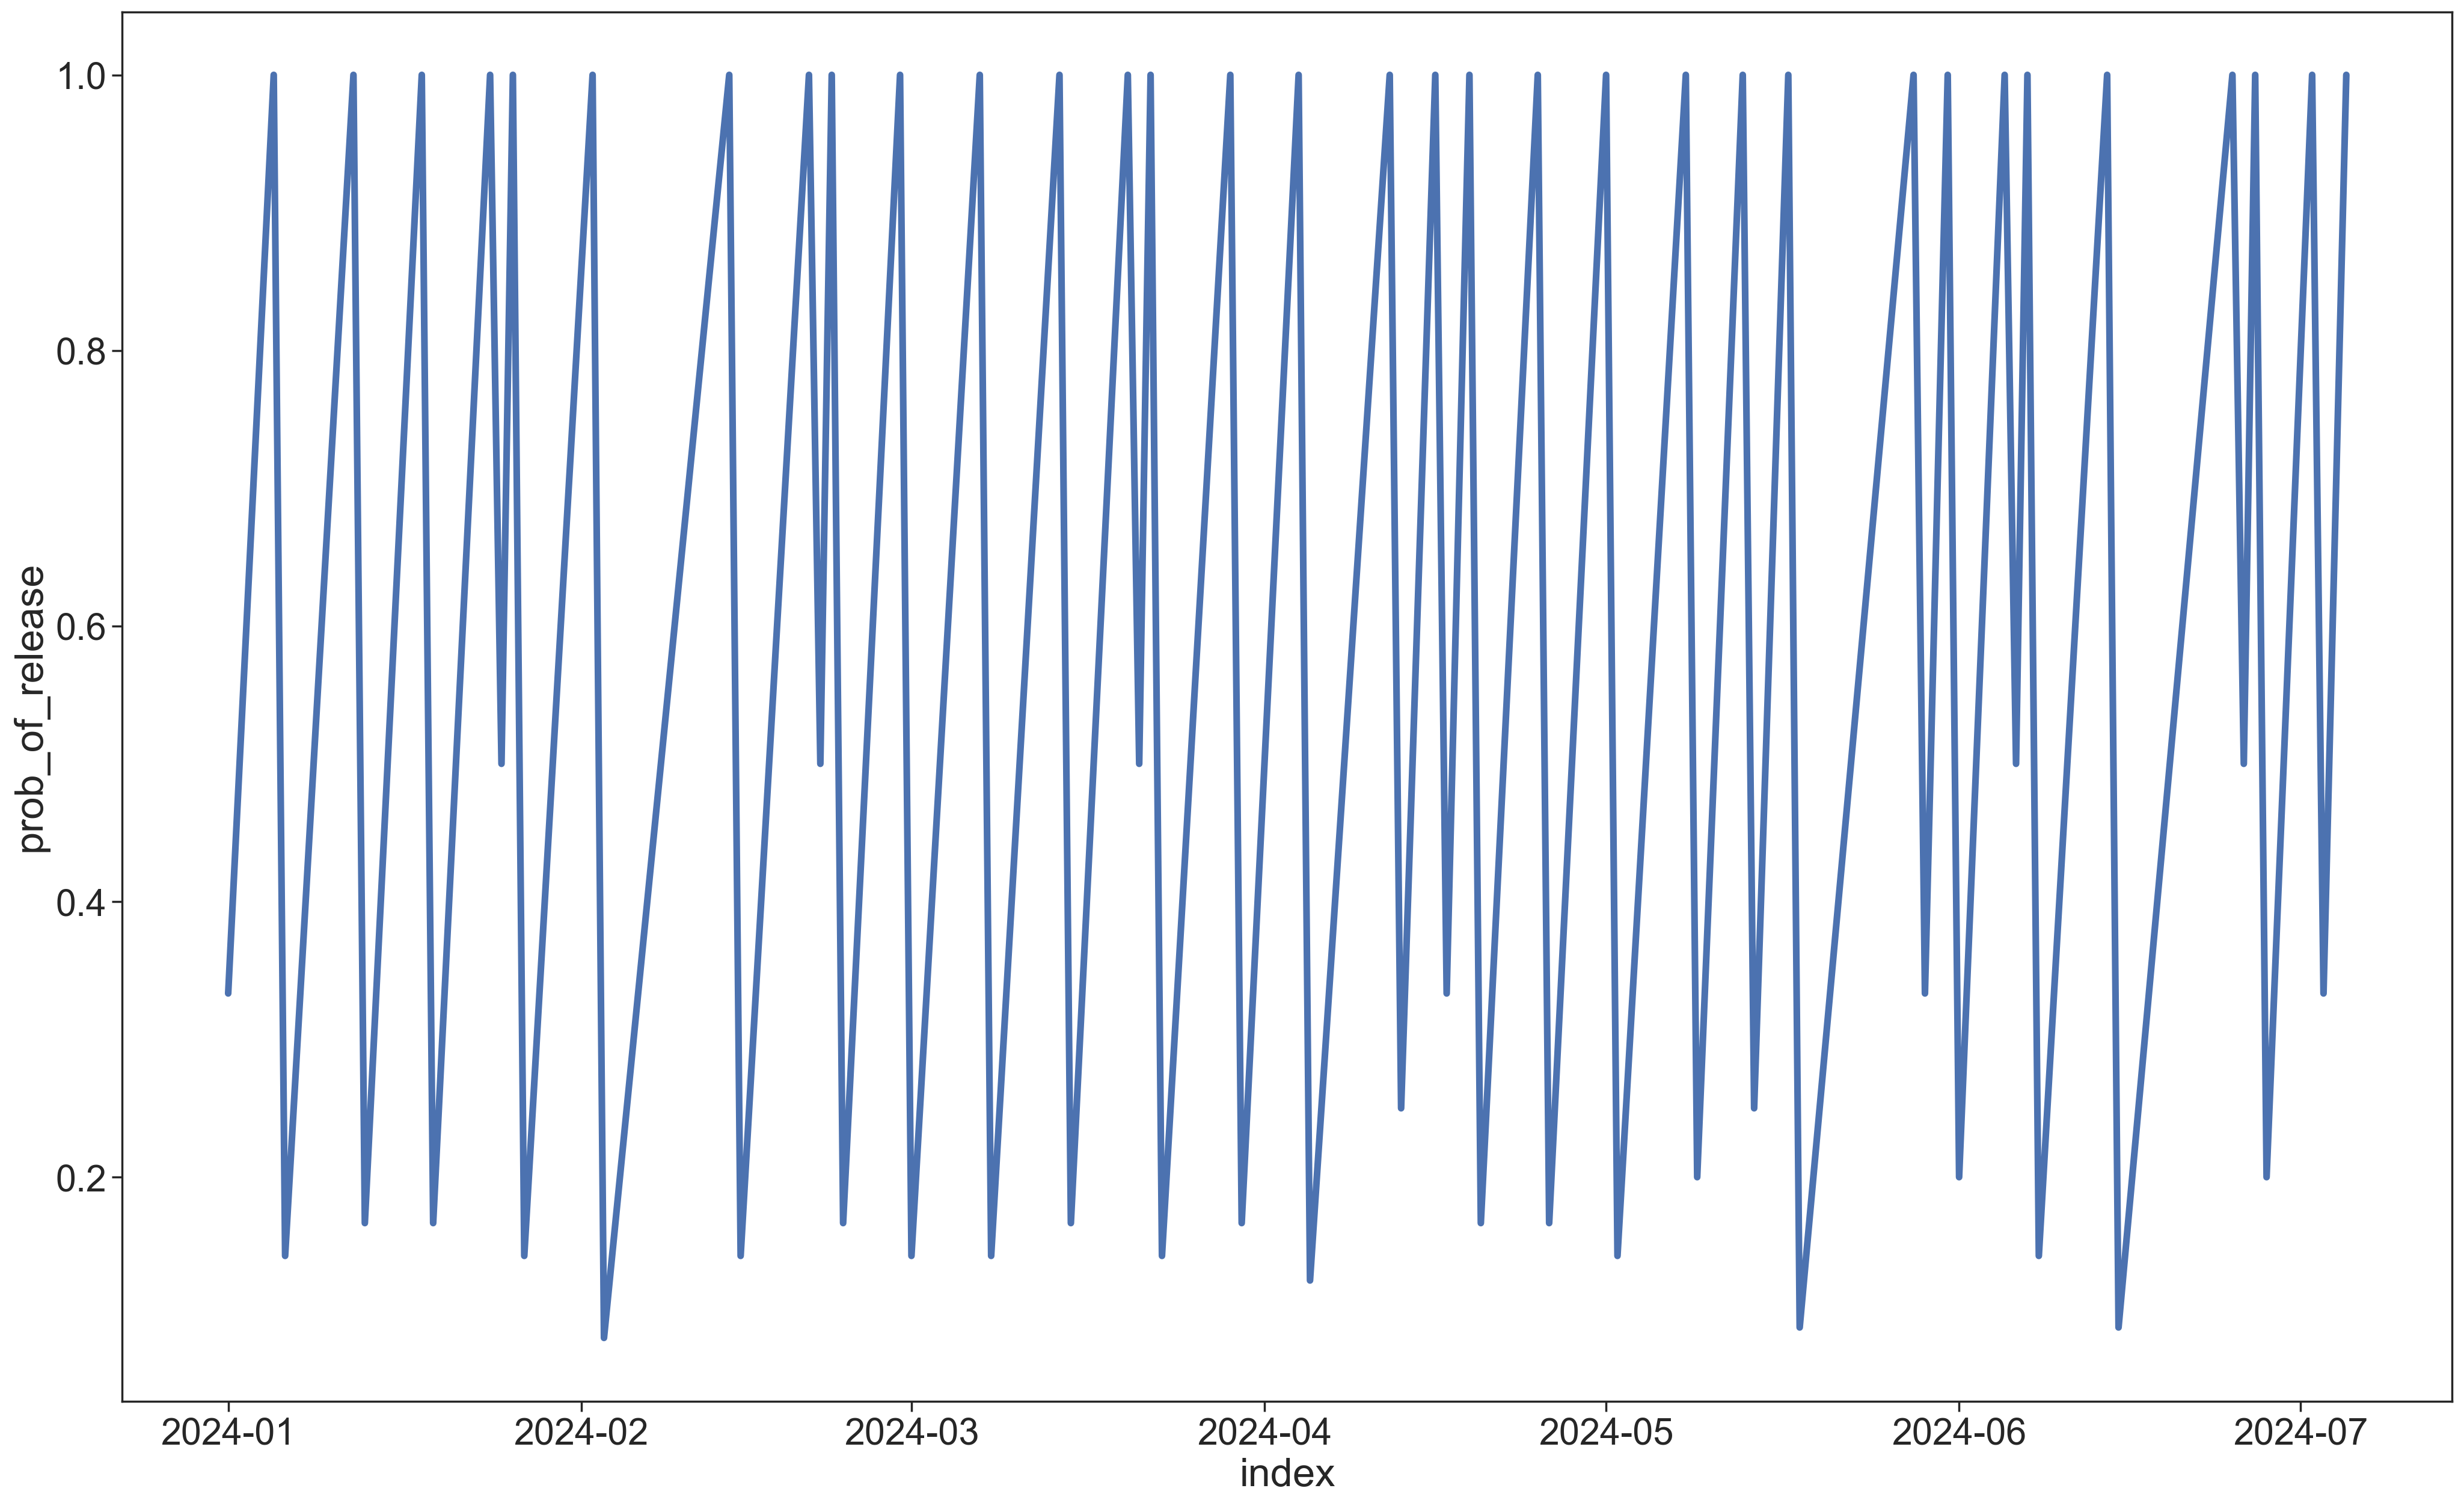

In [5]:
sns.lineplot(data=df[df["index"].dt.year == 2024], x="index", y="prob_of_release", linewidth=4)

---

<Axes: xlabel='days_since_previous_release', ylabel='Count'>

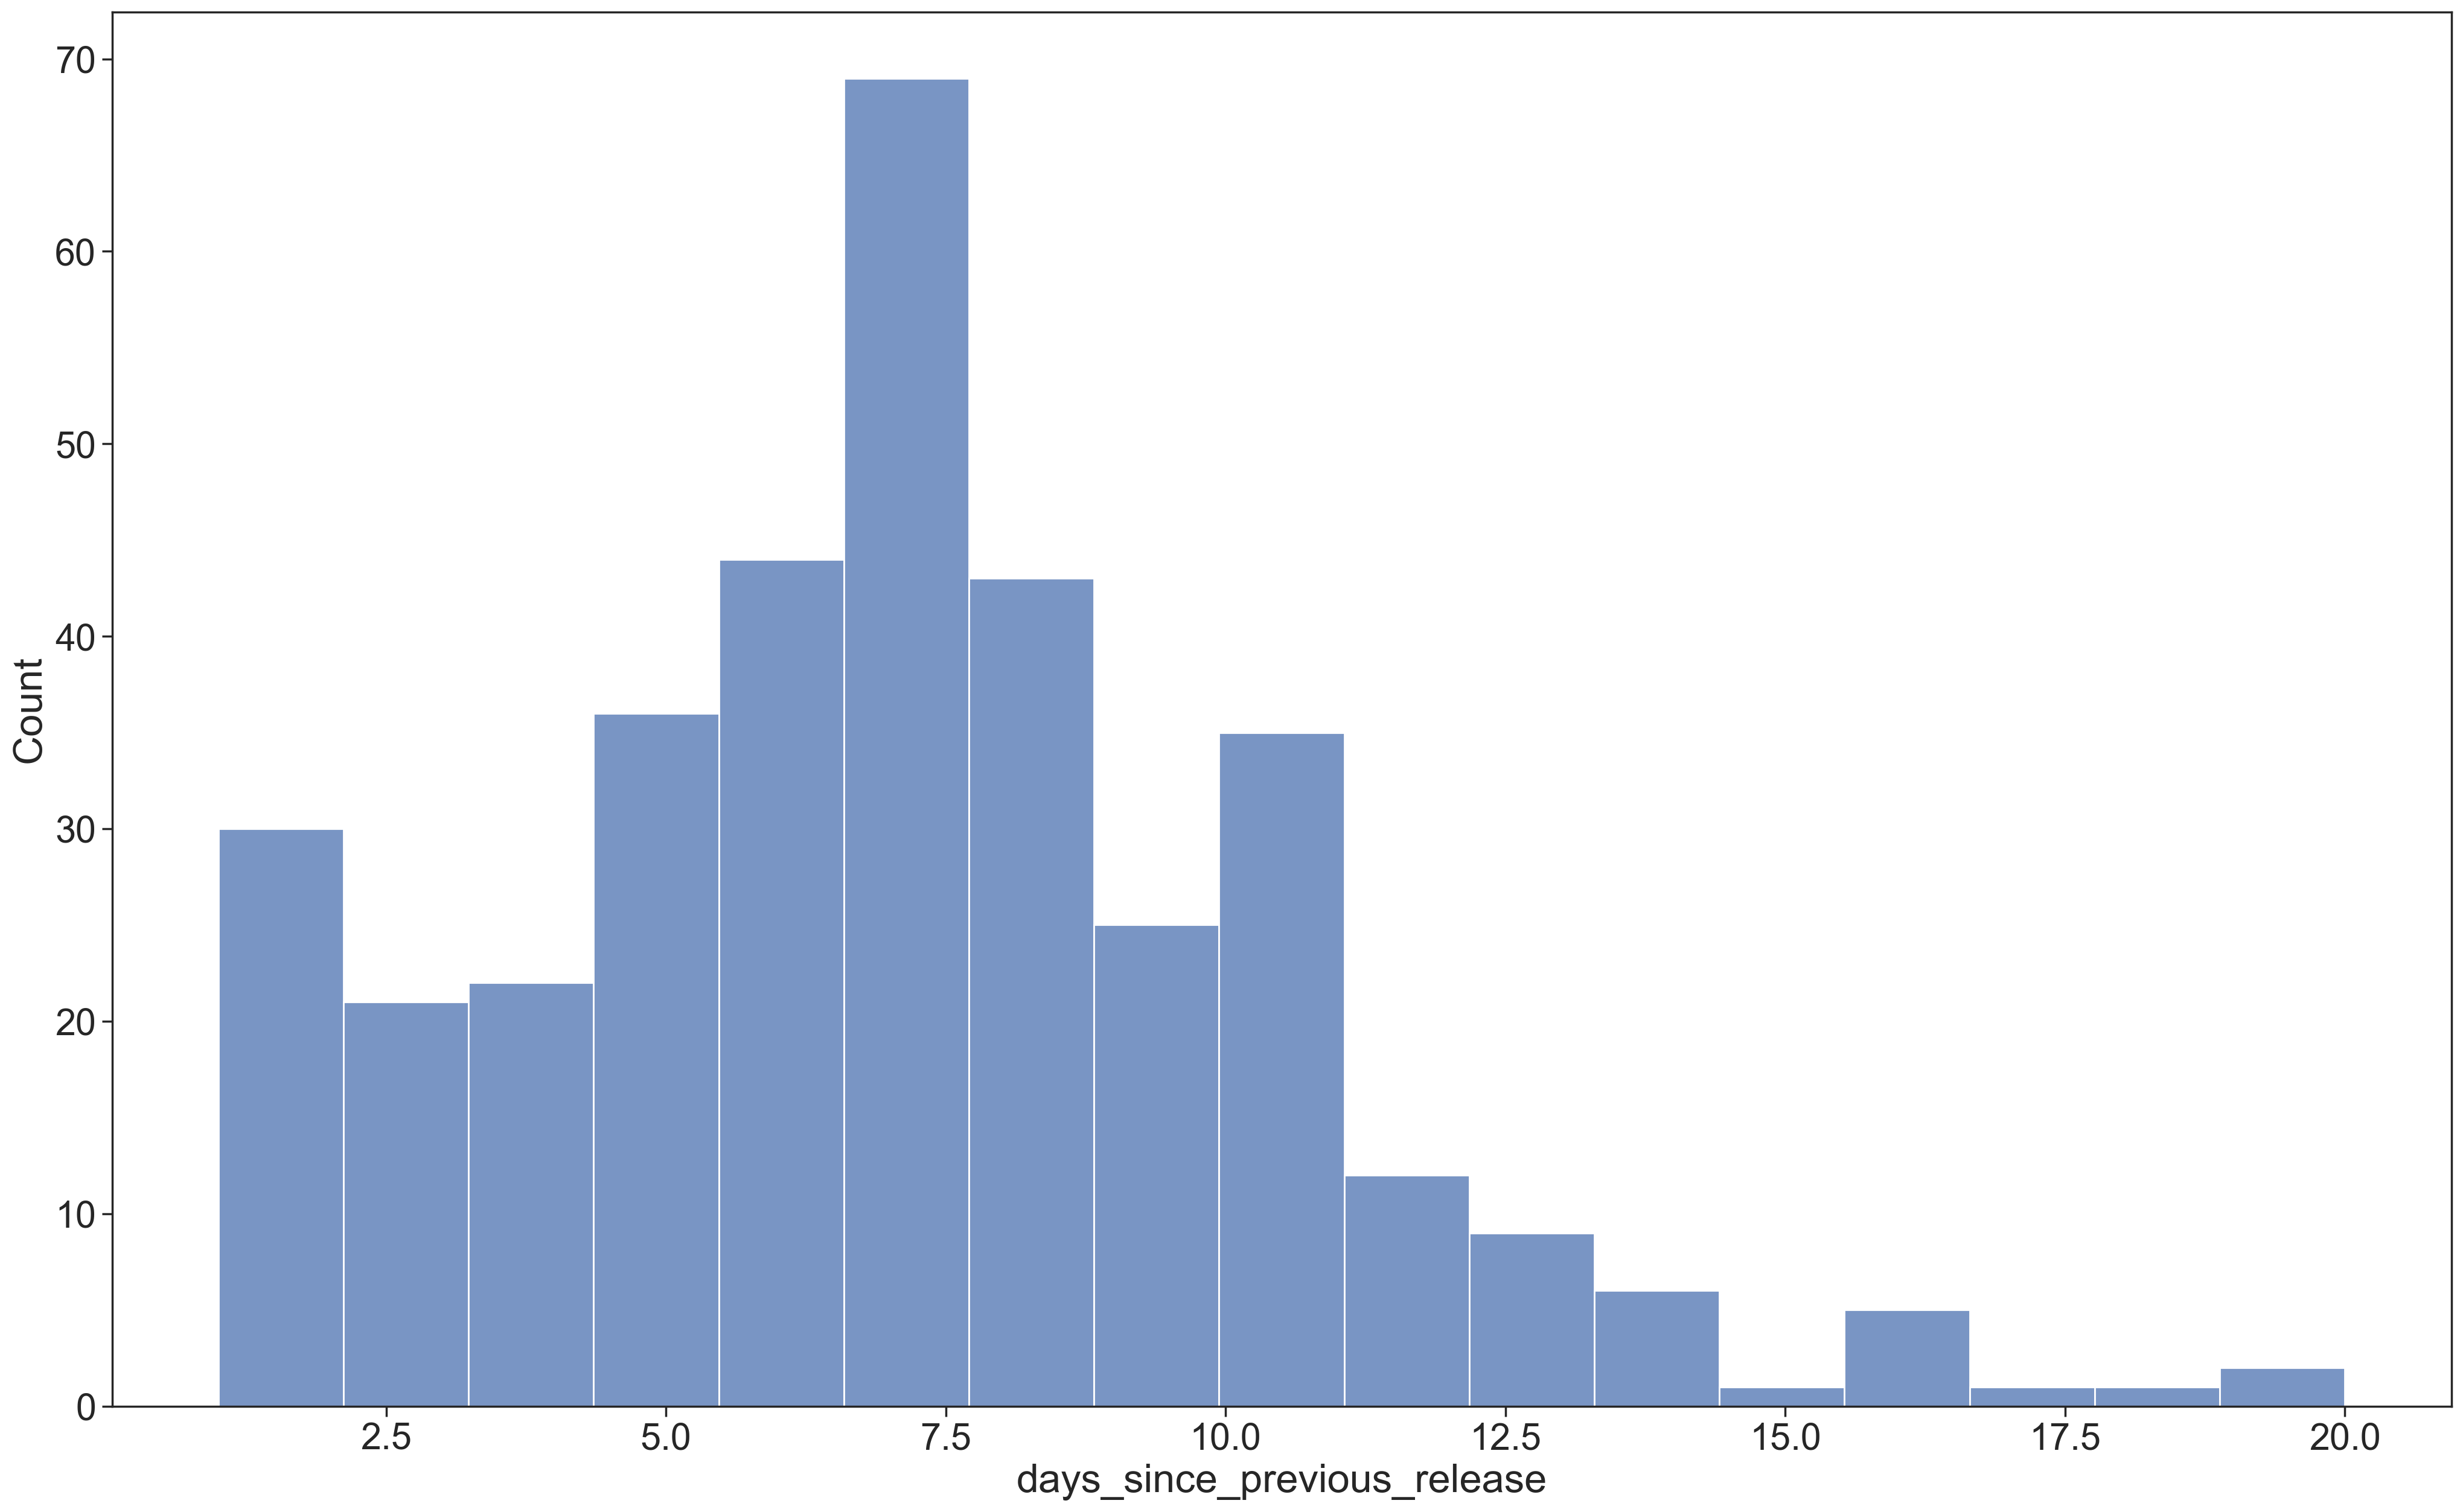

In [3]:
sns.histplot(x=df[df["prob_of_release"] == 1]["days_since_previous_release"])

---

In [5]:
df["release"] = (df["prob_of_release"] == 1).astype(int)

In [7]:
df = df.set_index("index")

In [15]:
df.resample("W")["release"].sum().value_counts()

release
1    243
0     68
2     58
3      1
Name: count, dtype: int64

In [16]:
df.resample("W")["release"].sum().value_counts() / df["release"].sum()

release
1    0.671271
0    0.187845
2    0.160221
3    0.002762
Name: count, dtype: float64

In [69]:
np.log(0.187845)

-1.6721381242980315

In [70]:
# probability mass function

k = list(range(0, 10)) # number of release per week
p = [] # prob under Poisson distribution
mu = 1.6721381242980315

for i in k:
    p.append(np.exp(mu * -1) * ((mu ** i) / factorial(i)))

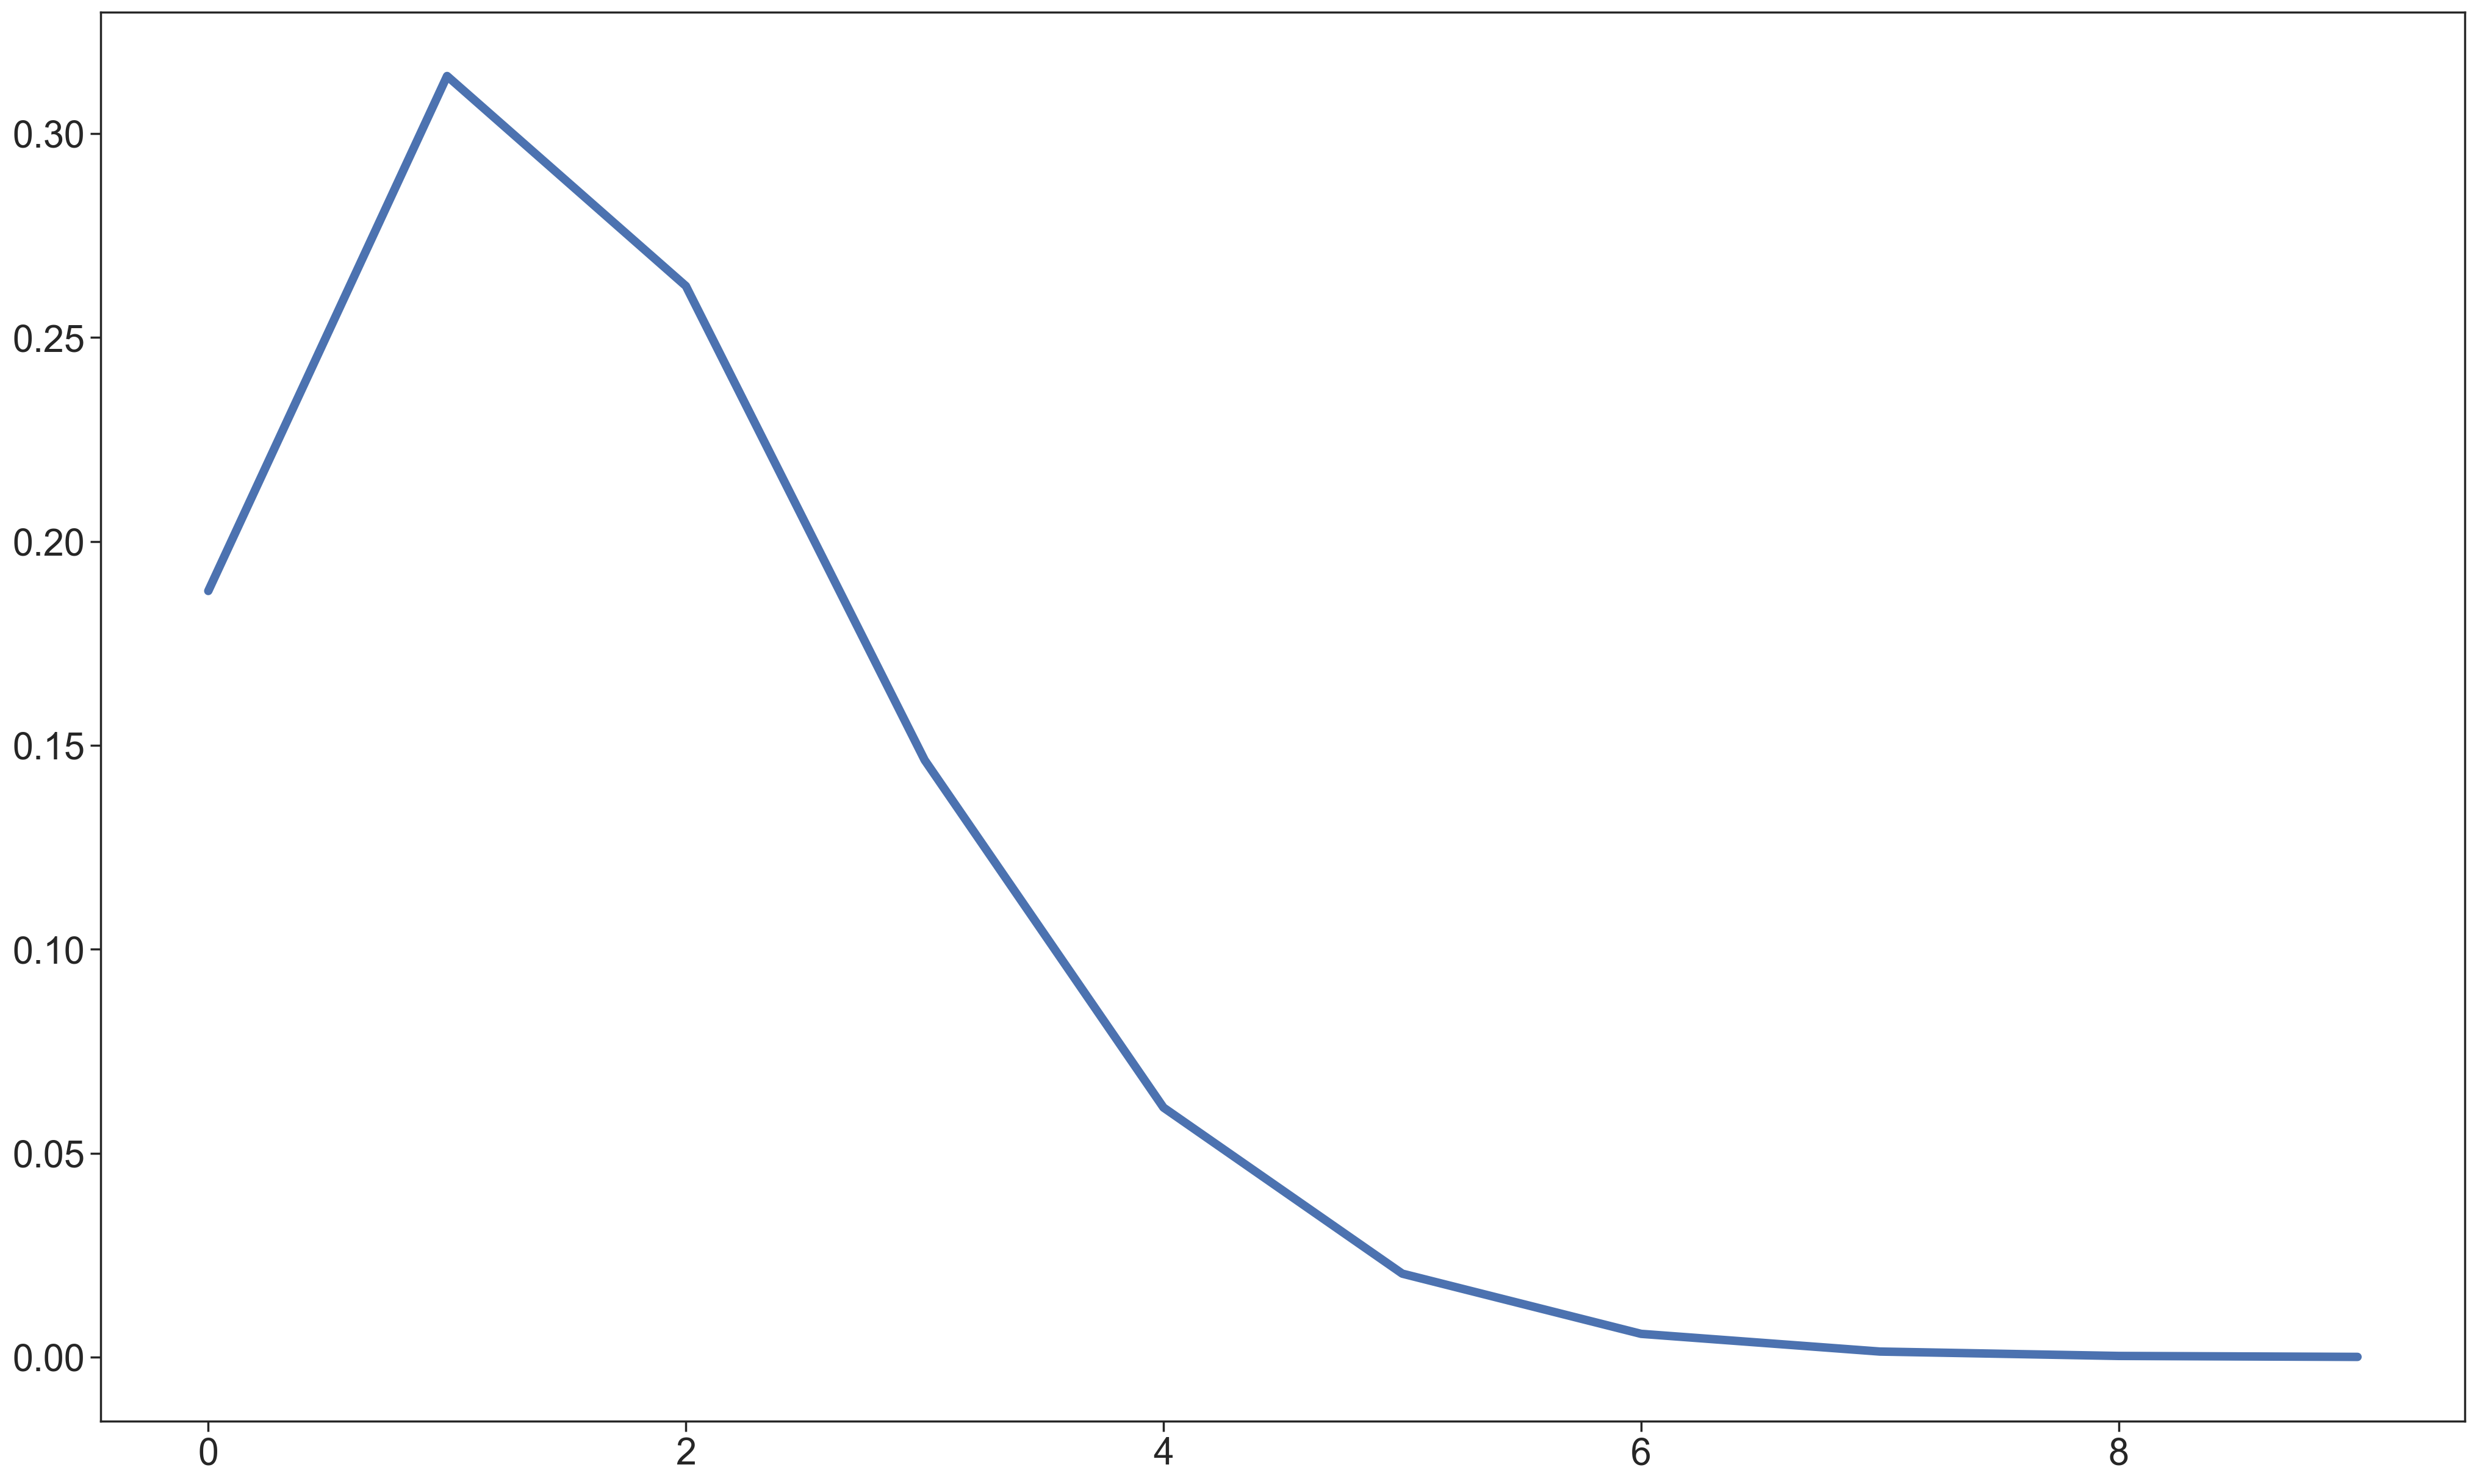

In [71]:
ax = sns.lineplot(x=k, y=p, linewidth=5)
plt.show()

In [72]:
poisson.pmf(mu=mu, k=1)

0.3141027859587638

In [73]:
p

[0.187845,
 0.31410278595876373,
 0.2626116216749366,
 0.14637430149546427,
 0.06118951248701505,
 0.020463463327349666,
 0.0057029561974726705,
 0.0013623043541422554,
 0.000284745130932309,
 5.290368768223873e-05]

In [78]:
poisson.rvs(mu=mu, loc=((0 + 1 + 2 + 3) / 4), size=100)

array([2, 4, 2, 1, 3, 5, 2, 2, 3, 1, 2, 3, 4, 5, 3, 2, 2, 5, 7, 3, 2, 2,
       2, 3, 2, 1, 4, 3, 3, 4, 5, 3, 2, 3, 3, 3, 4, 2, 3, 4, 2, 4, 5, 2,
       3, 2, 3, 1, 3, 3, 3, 3, 4, 3, 2, 3, 2, 3, 1, 3, 4, 3, 2, 3, 1, 1,
       5, 3, 2, 3, 1, 4, 2, 2, 3, 2, 1, 3, 4, 2, 3, 1, 3, 4, 1, 4, 6, 1,
       3, 4, 2, 2, 5, 2, 2, 1, 3, 3, 2, 6])

In [79]:
(0 + 1 + 2 + 3) / 4

1.5

---

In [174]:
temp = df[df["release"] == 1].copy().reset_index()
temp["index"].dt.year.value_counts() / 52

index
2023    1.115385
2022    1.096154
2021    1.057692
2019    1.019231
2020    0.884615
2018    0.807692
2017    0.750000
2024    0.230769
Name: count, dtype: float64

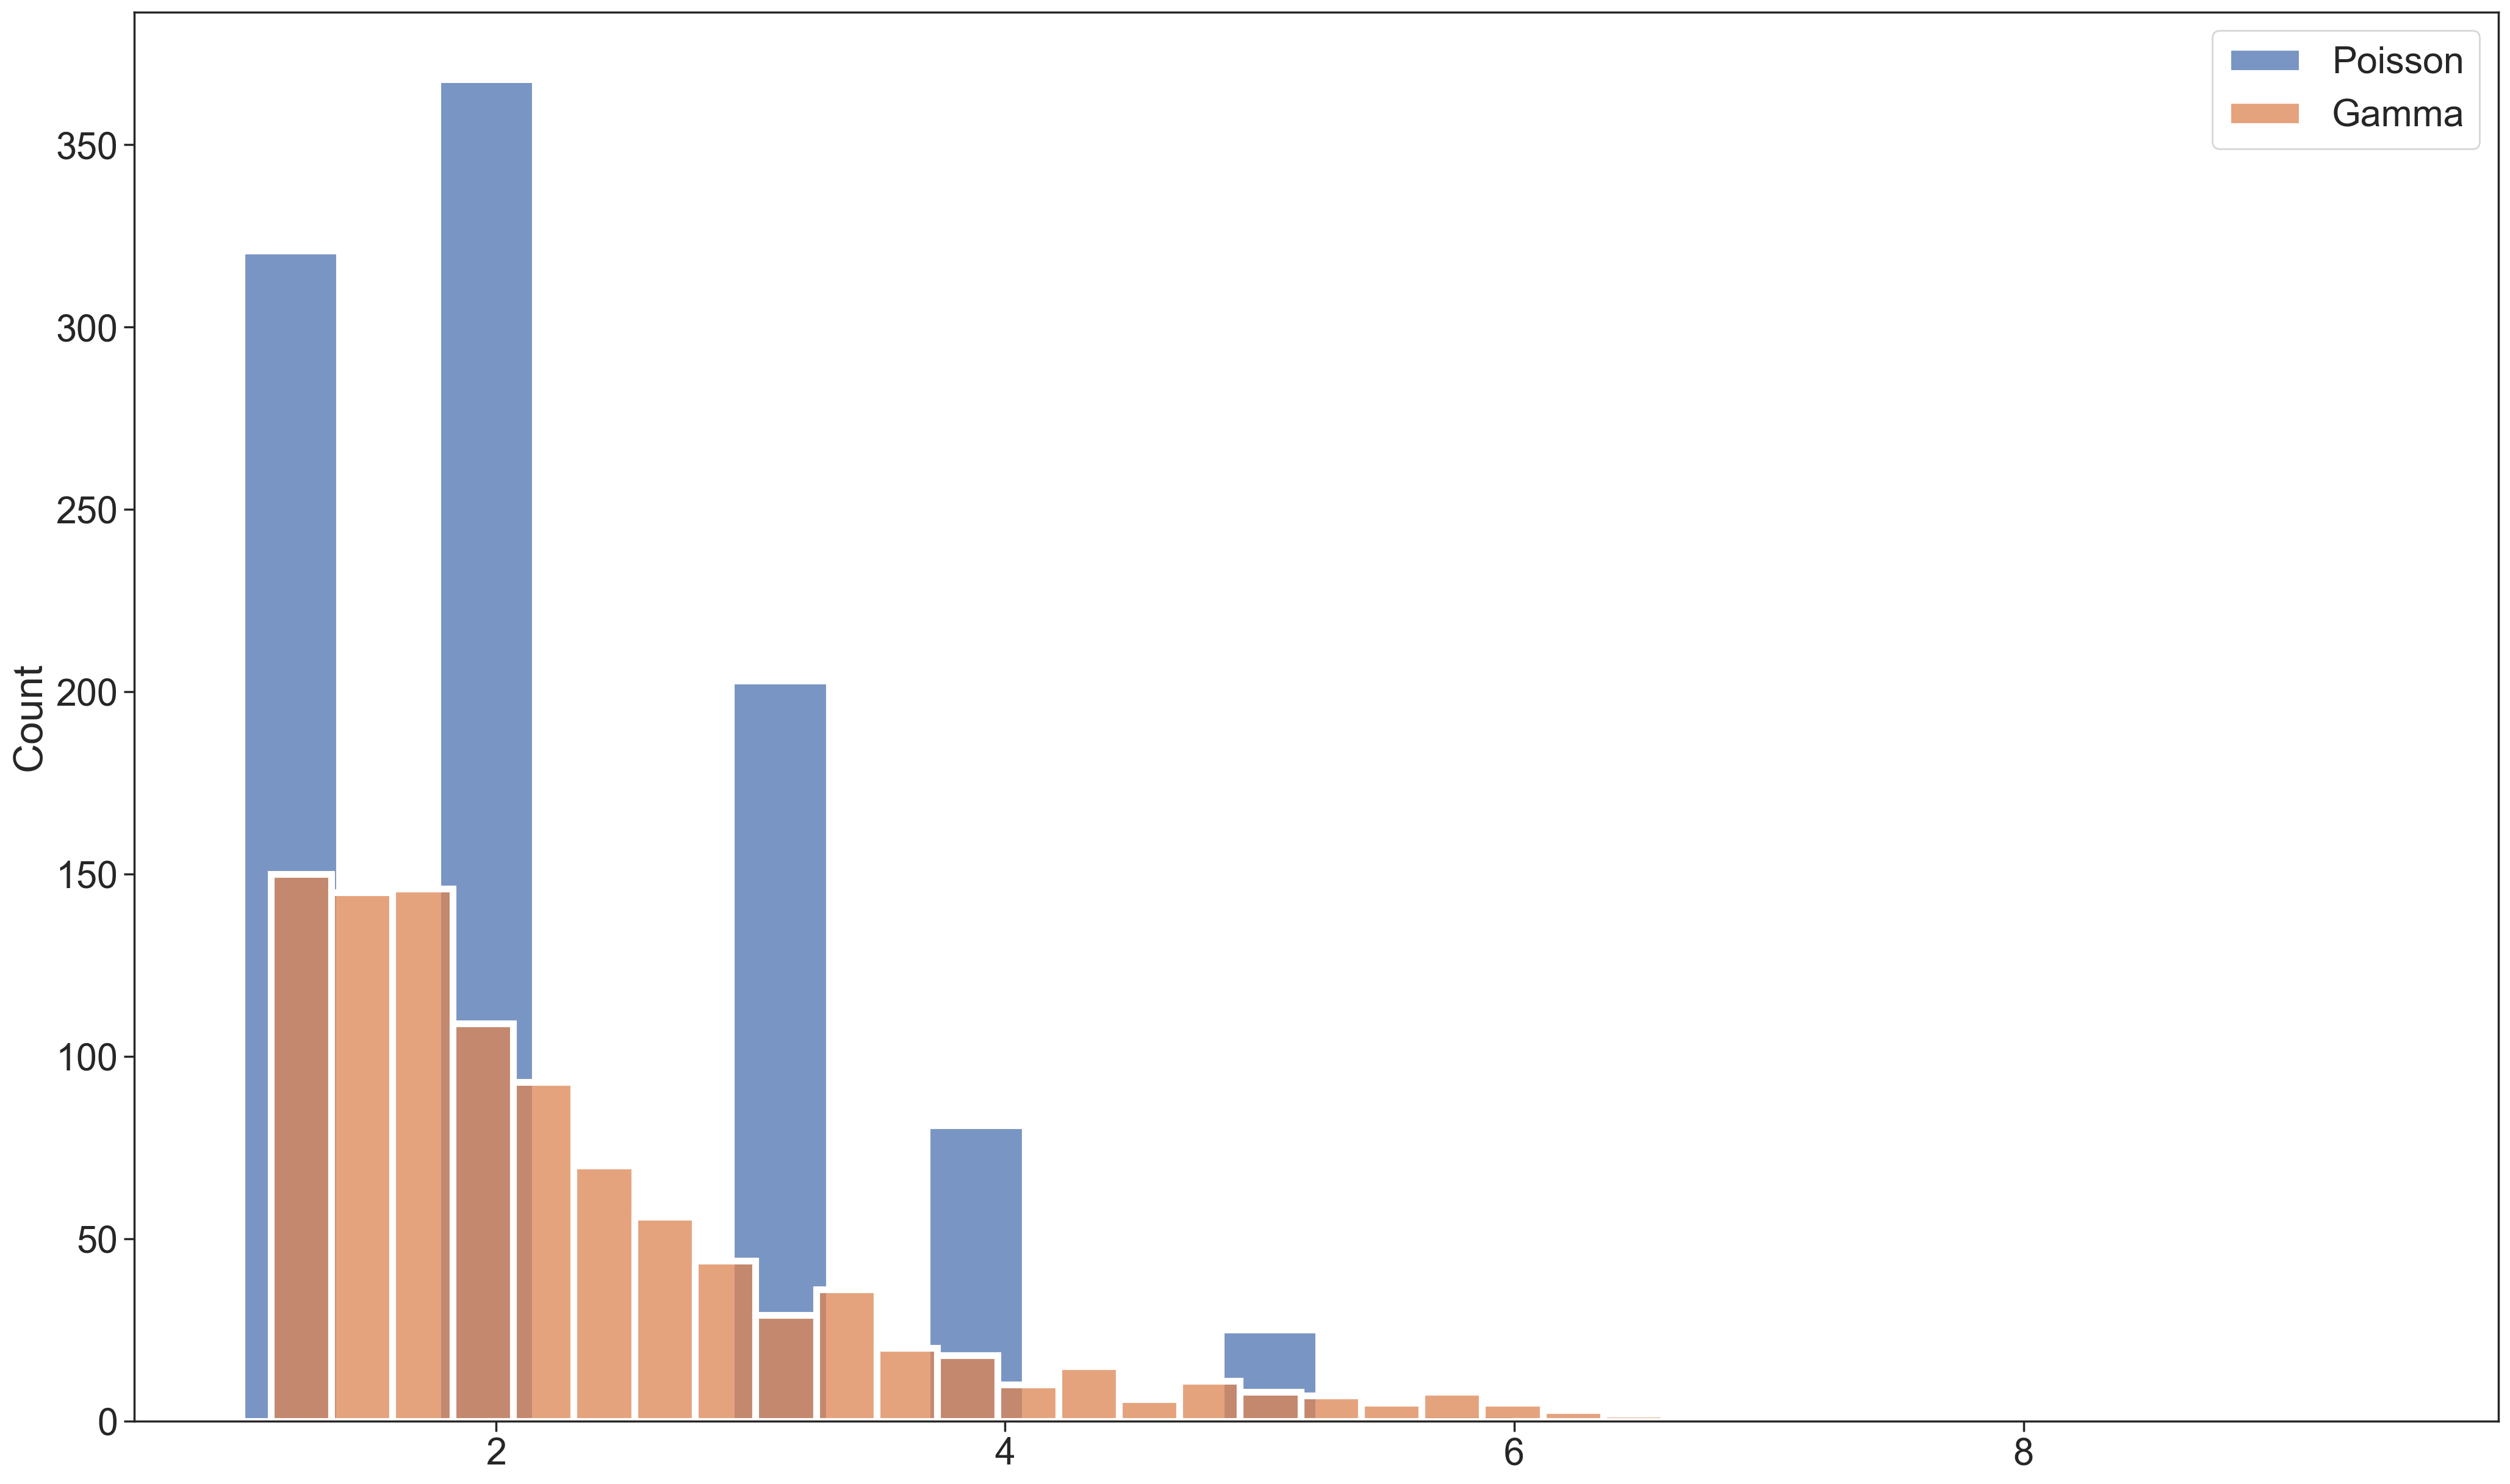

In [199]:
# ax = sns.kdeplot(x=expon.rvs(loc=2, scale=1, size=1000), linewidth=4, label="Exponential")
ax = sns.histplot(x=poisson.rvs(mu=1.115385, loc=1.115385, size=1000), linewidth=4, label="Poisson")
sns.histplot(x=gamma.rvs(a=1.115385, loc=1.115385, size=1000), linewidth=4, label="Gamma", ax=ax)
ax.legend()
plt.show()

---